# Using GAN to upscale images 

main paper : 

#https://arxiv.org/abs/1609.04802

additional:

1. recidual blocks

НАЙДЕНО https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

2. pixelshuffle

https://arxiv.org/pdf/1609.05158.pdf

https://keras.io/examples/vision/super_resolution_sub_pixel/

Error: -

# Table of contents
1. [Importing libraries and packages](#IMPORTING-LIBRARIES-AND-PACKAGES)  
   1.1. [General settings](#General-settings)
3. [Model](#Model)  
   3.1. [Generator-submodel](#Generator-submodel)  
   3.2. [Discriminator-submodel](#Discriminator-submodel)  
4. [LOSS FUNCTIONS](#LOSS-FUNCTIONS)  
   4.1. [Generator loss](#Generator-loss)  
   4.2. [Discriminator loss](#Discriminator-loss)  
5. [TRAINING](#TRAINING)  
   5.1 [Loading dataset](#Loading-dataset)  
   5.2 [Training parameters](#Training-parameters)
   
[TEST](#TEST)  

# IMPORTING LIBRARIES AND PACKAGES

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.22.0
ipywidgets       : 8.0.4
jupyter_client   : 8.2.0
jupyter_core     : 5.3.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.8
nbclient         : 0.8.0
nbconvert        : 7.11.0
nbformat         : 5.9.2
notebook         : 7.0.6
qtconsole        : not installed
traitlets        : 5.9.0


In [2]:
#visualization of data
from PIL import Image
import matplotlib.pyplot as plt 
#technical tool to for saving temporary files
import os
import datetime
import time
#main libraries
import numpy as np
from pandas import DataFrame, ExcelWriter
import tensorflow as tf

#tuning

#prevent tensorflow from allocating all GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
#try:tf.config.experimental.set_memory_growth(physical_devices[0], True)
#except:pass

print("GPU:", physical_devices)
print("TensorFlow version:", tf.__version__)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.1


## General settings

In [3]:
#weight made by model.save_weights
load_weights = False
#weight made by tf.train.CheckpointManager
resotre_weights = True

#names for model.save_weights directive
weights_folder = "weights_modver/"
weights_file_index = "_main"

#
TRAINING = True

**secondary functions**

In [4]:
#output image with matplotlib
def visualize(img_data, path=None): #input can be image or batch or tensorflow iterator
    temp = np.array(img_data)
    print(temp.shape)
    if len(temp.shape) < 4:
        temp = np.expand_dims(temp, 0)
    fig, ax = plt.subplots(ncols=len(temp), figsize=(10, 10), squeeze=False)
    for indx, img in enumerate(temp):
        ax[0][indx].imshow(img)

def none_quntity(x):
    if x: return x
    else: return 0

# Model

## Generator-submodel

* GAN uses two models, a generator model that generates output and a discriminator model that classifies wether the output is generated by the generator model(fake) or taken from the dataset(real)

* The generator model is a U-Net. It is a neural network used for image to image tasks. It has three major components : downsampling blocks, upsampling blocks and skip connections.

* Downsampling blocks convert image input to tensors of lower dimesions until it becomes a 1D tensor. Upsampling blocks convert output of downsampling blocks back to image output. Skip connections provide connections between downsampling and upsampling blocks at each level.

* Generator and discriminator compete against each other.

pixel shuffler 

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1609.05158.pdf


In [5]:
#repeatable generator part
def generator_block(filters, size, name=None):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    #relu02= lambda x: tf.keras.activations.relu(x, alpha=0.2)
    
    result = tf.keras.Sequential(name=name)
    
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                      **conv_args)) 
    result.add(tf.keras.layers.BatchNormalization())    
    result.add(tf.keras.layers.Activation('relu',
                                         trainable=False))
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                     **conv_args))
    result.add(tf.keras.layers.BatchNormalization())
        
    return result

#upsumpling submodel/layer
def pixelshuffler(size, filters, up_factor=2):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inp = tf.keras.layers.Input(shape=[None, None, filters],
                                ragged=True,
                                dtype=tf.float32,
                                name='shuf_input')
    inp = inp.to_tensor()
    x = tf.keras.layers.Conv2D(
        filters*up_factor*up_factor, 
        size, 
        **conv_args)(inp)
    x = tf.nn.depth_to_space(x, up_factor)
    outputs = tf.keras.layers.Activation('relu',
                                        trainable=False)(x)
    return tf.keras.Model(inp, outputs)

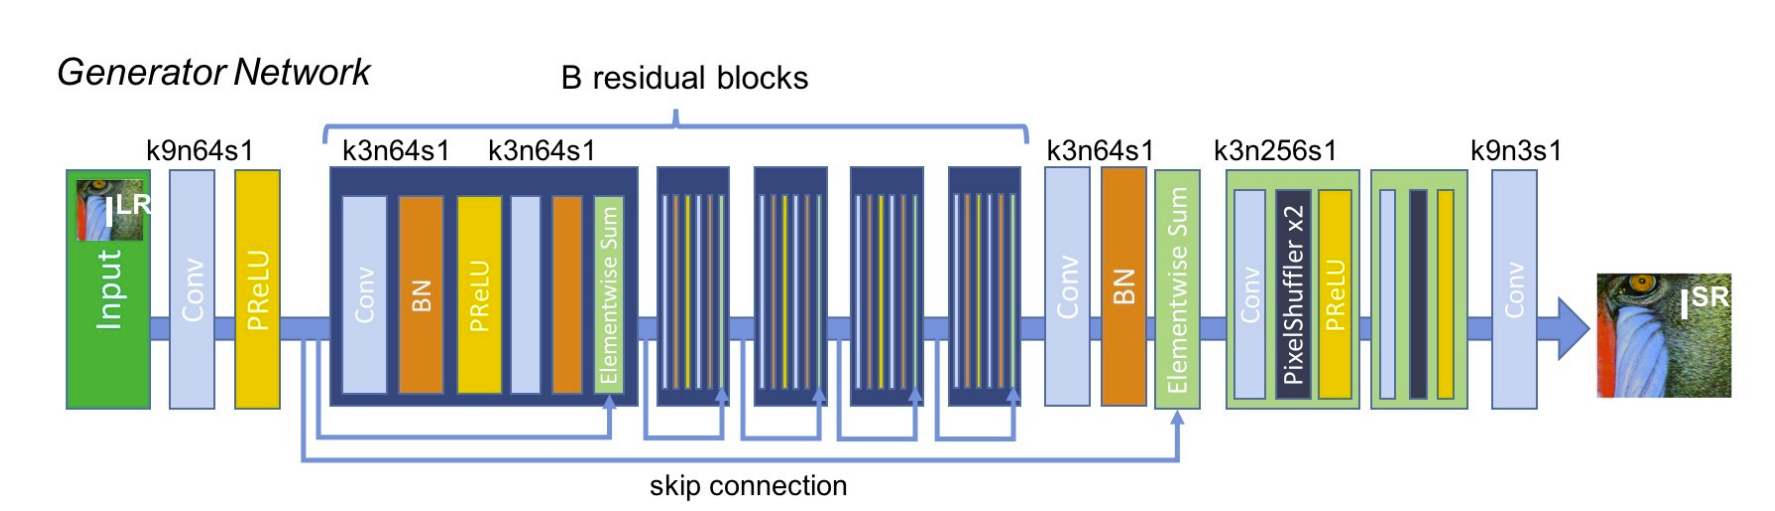

In [6]:
#model to upsampling low resolution images
#getting as input any image and giving as output image with resolution*8
def Generator():   
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    b_residual_block = [generator_block(64,3,name="brb"+str(i)) for i in range(16)] #16
    
    inp = tf.keras.Input(shape=[None, None, 3],
                         ragged=True)
    inp = inp.to_tensor(name='gen_input_image')
    
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=9,
                               activation='relu',
                               **conv_args)(inp)
    temp = x
    for layer in b_residual_block:
        x = tf.math.add(x, layer(temp))
        
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=3,
                               **conv_args)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.add(x, temp)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = pixelshuffler(
            filters=64,
            size=3)(x)
    x = tf.keras.layers.Conv2D(
        filters=3, 
        kernel_size=9,
        activation=tf.keras.activations.sigmoid,
        **conv_args)(x) 
    
    return tf.keras.Model(inputs = inp, outputs = x, name="generator")

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_32 (Conv2D)             (None, None, None,   15616       ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 brb0 (Sequential)              (None, None, None,   74368       ['conv2d_32[1][0]']              
                                64)                                                       

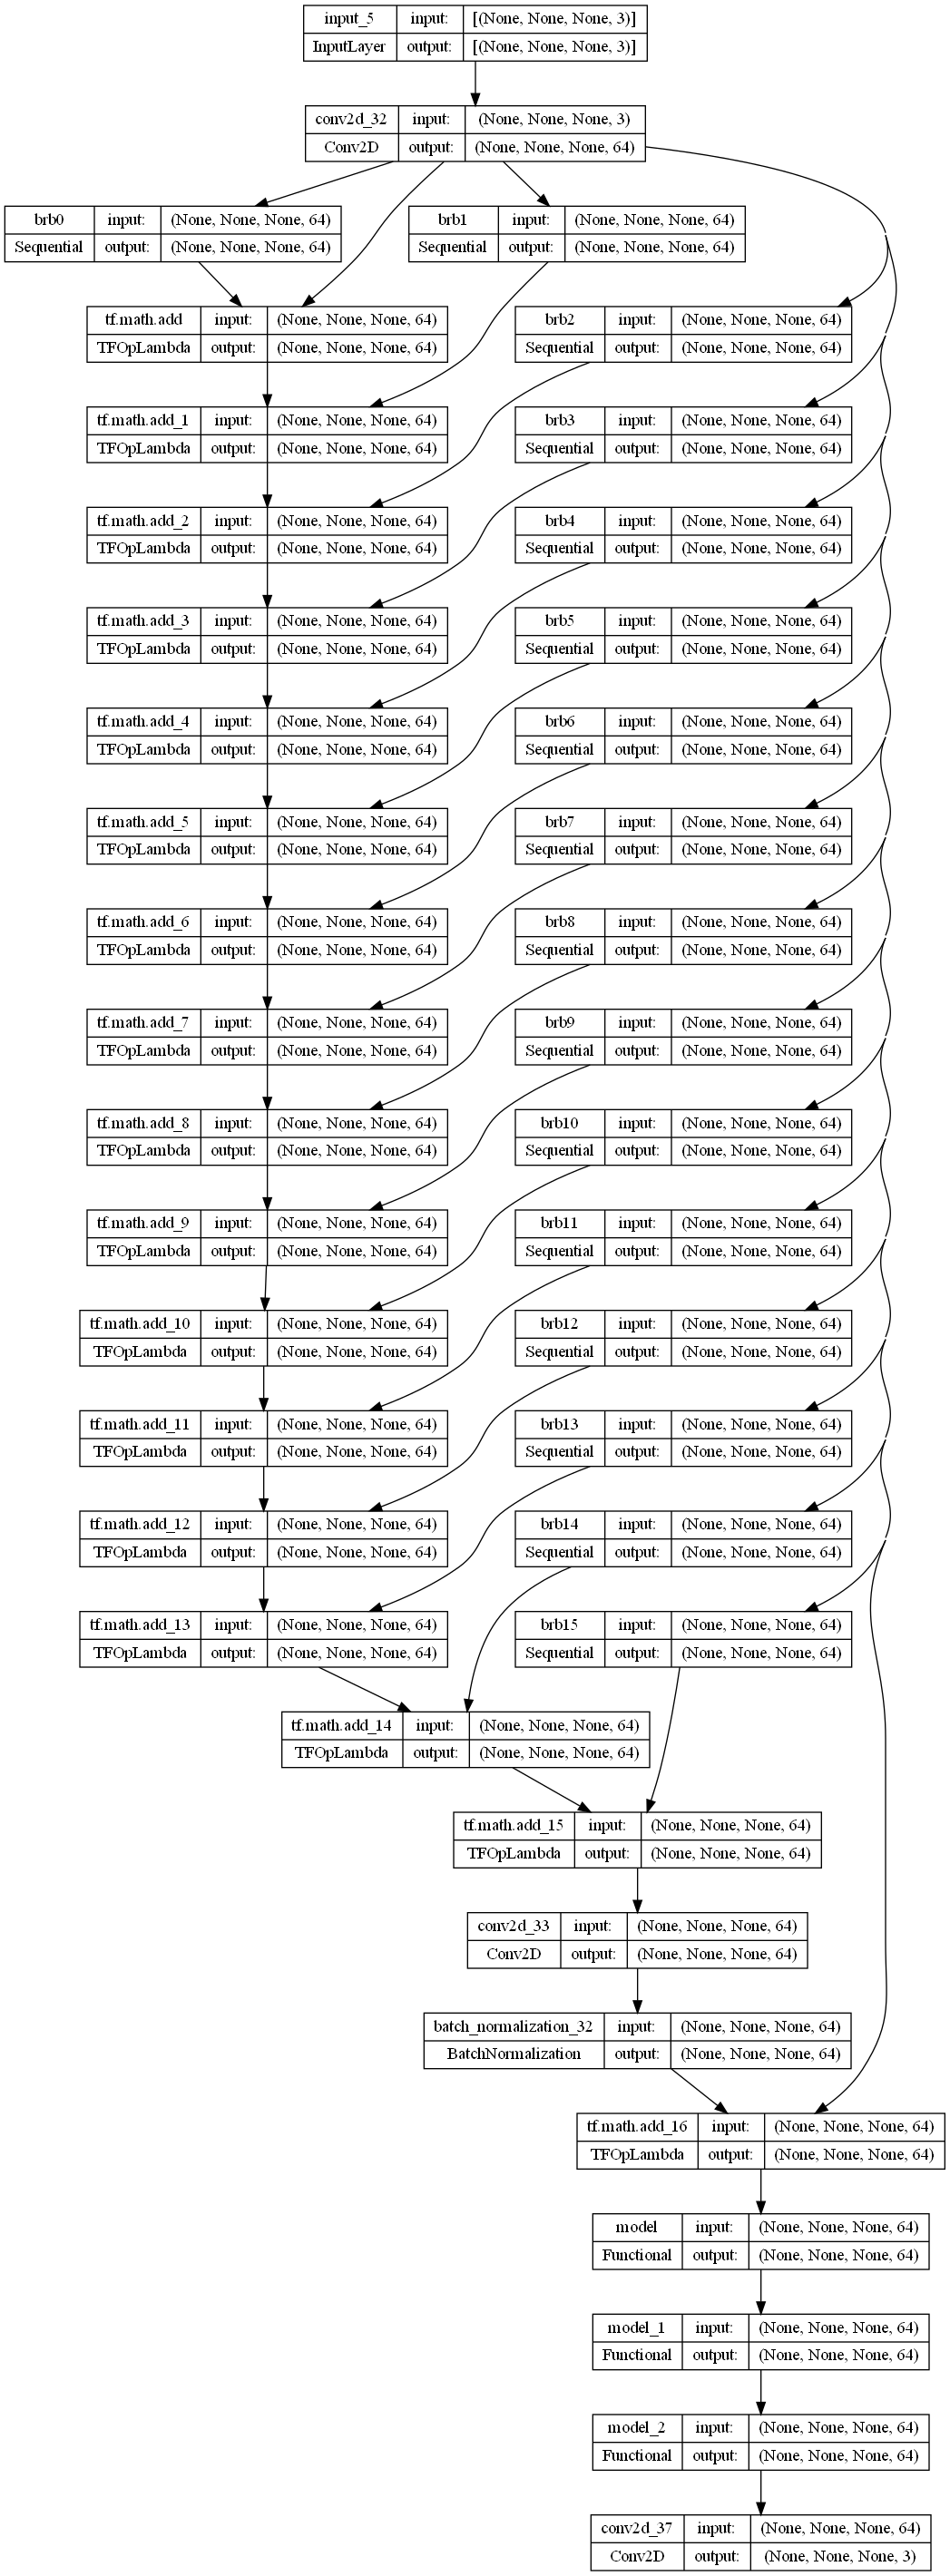

In [7]:
#initialize generator
generator = Generator()

if load_weights == True and weights_file_index != None:
    generator.load_weights(weights_folder + "generator" + weights_file_index)

#summary of trainable weight
generator.summary()
#plot the model grathp
tf.keras.utils.plot_model(generator, show_shapes = True)

## Discriminator-submodel

* Discriminator model is a PatchGAN
* In a PatchGAN, the output is a 3D vector referring to similarity between patches of input and target images
* Model consists of downsampling blocks : Conv->BatchNorm->LeakyReLU
* It receives two inputs : Input image and generated image which is classified as fake and input image and target image which is classified as real

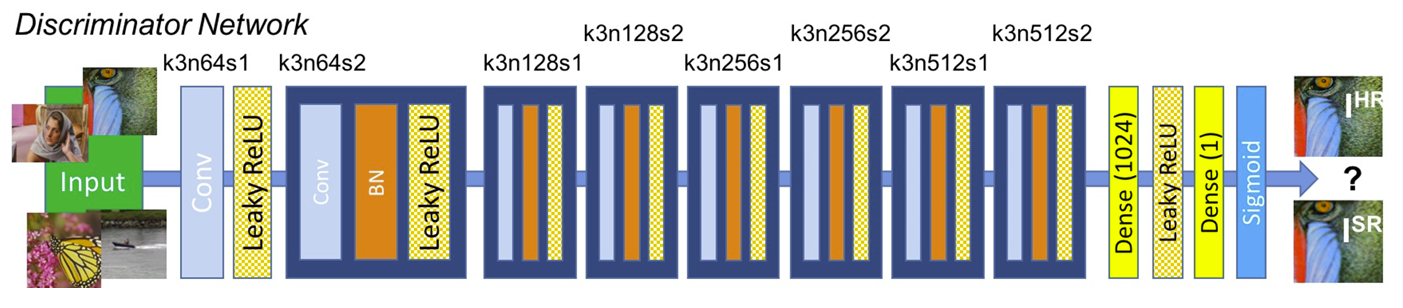


In [8]:
#repeatable discriminator part
def discriminator_block(filters, size, strides = 1):
    initializer = tf.random_normal_initializer(0. , 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides, 
                                       padding='same',
                                       kernel_initializer=initializer))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(alpha=0.2,
                                        trainable=False))
    
    return result

#test dropout

#model for recognizing true photos among generated images
#getting an input array of images and giving an output array of values from 0 to 1 for each pixel
def Discriminator():
    #inputs = tf.keras.layers.Input(shape = [512,512,3])
    initializer = tf.random_normal_initializer(0. , 0.02)

    inputs = tf.keras.Input(shape=[None, None, 3],
                            ragged=True)
    inputs = inputs.to_tensor(name='dis_input_image')
    
    #discriminator_block
    #feature map x2 each layer, 
    #kernel 3x3, 
    #strides on every second layer that downsampling image
    down_stack = [
        tf.keras.layers.Conv2D(64,3,
                                padding='same',
                                kernel_initializer = initializer),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                 trainable=False),
        discriminator_block(64, 3, 2), 
        discriminator_block(128, 3, 1),
        discriminator_block(128, 3, 2),
        discriminator_block(256, 3, 1),
        discriminator_block(256, 3, 2), 
        discriminator_block(512, 3, 1), 
        discriminator_block(512, 3, 2),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                 trainable=False),
        tf.keras.layers.Dense(1),
        tf.math.sigmoid,
    ]
    x = inputs
    for down in down_stack:
        x = down(x)
    #x = tf.reduce_mean(x,1)
    #x = tf.reduce_mean(x,1)
    return tf.keras.Model(inputs = inputs, outputs = x, name="discriminator")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 sequential (Sequential)     (None, None, None, 64)    37184     
                                                                 
 sequential_1 (Sequential)   (None, None, None, 128)   74368     
                                                                 
 sequential_2 (Sequential)   (None, None, None, 128)   148096    
                                                                 
 sequential_3 (Sequential)   (None, None, None, 256) 

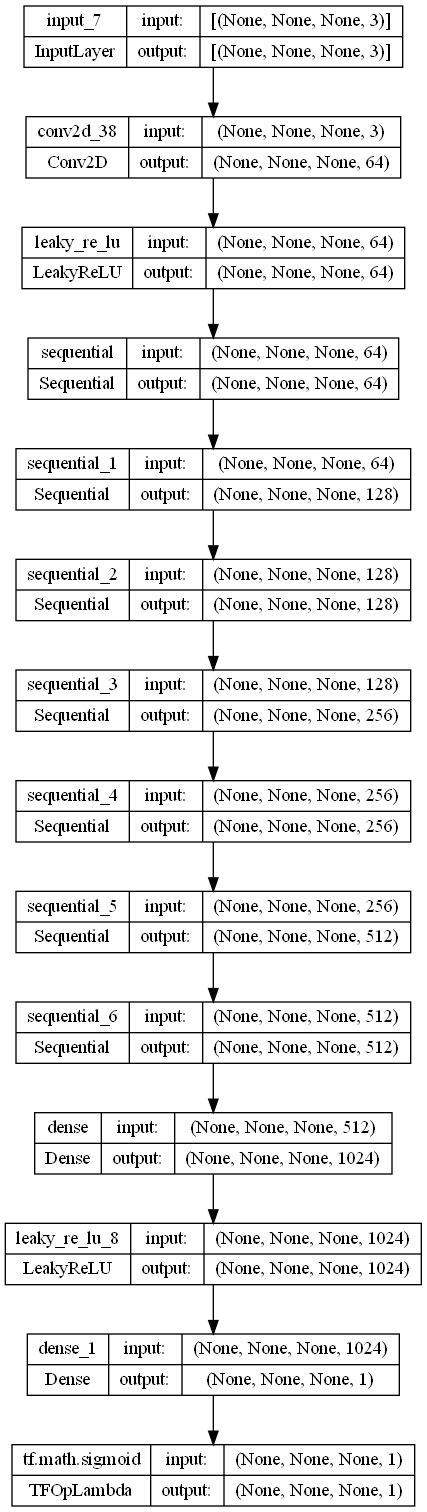

In [9]:
#initializing discriminator
discriminator = Discriminator()

if load_weights == True and weights_file_index != None:
    discriminator.load_weights(weights_folder + "discriminator" + weights_file_index)

#summary of trainable variables
discriminator.summary()
#plot the modle grathp
tf.keras.utils.plot_model(discriminator, show_shapes=True)

# LOSS FUNCTIONS

## Generator loss

* Generator loss consists of two components
* L1 loss which is mean absolute error between the generated image and target image to make generated images structurally similar to target images
* GAN loss which is binary crossentropy loss of discriminator's output on generated images and array of ones.
* Total loss = GAN loss + (LAMBDA * L1 loss)

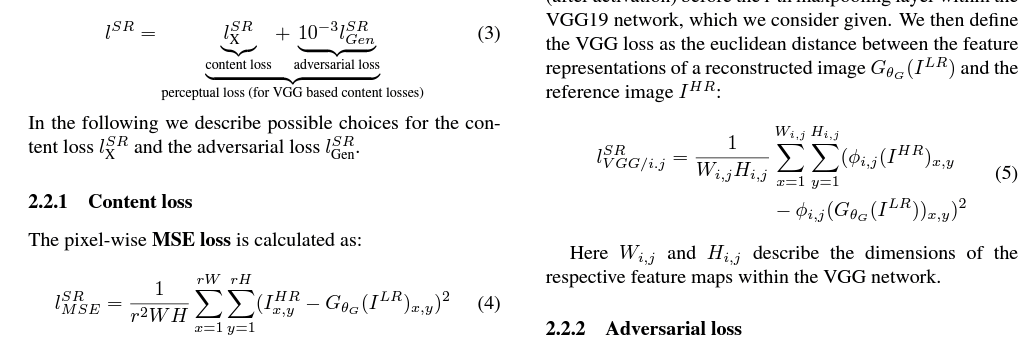
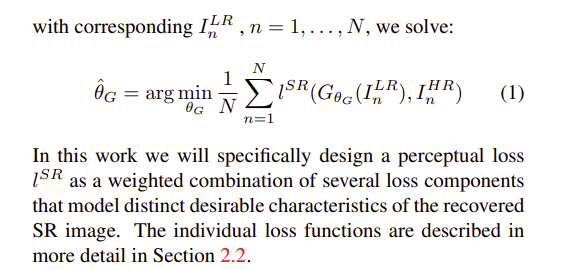

## Discriminator loss

* It takes two inputs : discriminator output for real images and generated images and it has two components : real loss and generated loss
* real loss is sigmoid cross entropy loss of real image output and array of ones
* generated loss is sigmoid cross entropy loss of generated image output and array of zeros
* total loss is sum of real loss and generated loss

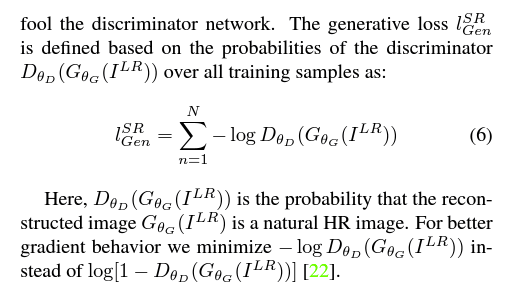

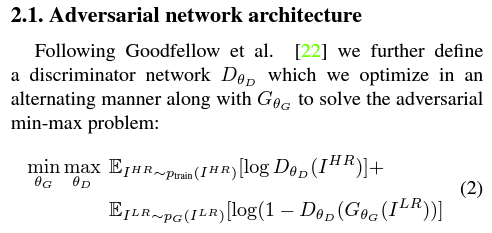

In [10]:
#for test
#adversarial_loss = tf.keras.losses.CategoricalCrossentropy()
#VGGmodel = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(512,512,3))

#declaring loss functions

def discriminator_loss(tar_img, gen_img):
    #input: B[H[W[C[0:1]]]]
    #B-Butch; H-Height; W-Width; C-Channels
    #and range of variance inside that array
    real_component = tf.reduce_mean(tar_img,1)  #B[W[C[0:1]]]
    real_component = tf.reduce_mean(real_component,1) #B[C[0:1]]
    real_component = tf.math.log(tf.ones_like(real_component) - real_component)     #B[C[-∞:0]]
    gen_component = tf.reduce_mean(gen_img,1)
    gen_component = tf.reduce_mean(gen_component,1)
    gen_component = tf.math.log(gen_component)
    log_loss = -tf.math.reduce_min(real_component+gen_component)
    del real_component, gen_component
    return log_loss

def generator_loss(gen_output, target, dis_probability=0):
    mse_loss = tf.keras.losses.MeanSquaredError()(target, gen_output)
    adv_loss = -tf.math.reduce_min(tf.math.log(dis_probability))
    total_gen_loss = mse_loss + adv_loss
    del mse_loss, adv_loss
    return total_gen_loss

**OPTIMIZERS AND CHECKPOINT SAVER**

In [11]:
#initialization and tuning of problem optimizer
DELTA = 1e-5
generator_optimizer = tf.keras.optimizers.Adam(DELTA, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(DELTA, beta_1=0.9)
#model saves manager
checkpoint_dir = "./training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir , max_to_keep=10)

    https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
    https://www.tensorflow.org/guide/data
    dataset3 = tf.data.Dataset.zip((dataset1, dataset2))


# TRAINING

## Loading dataset

Found 17137 files belonging to 1 classes.
(5, 512, 512, 3)


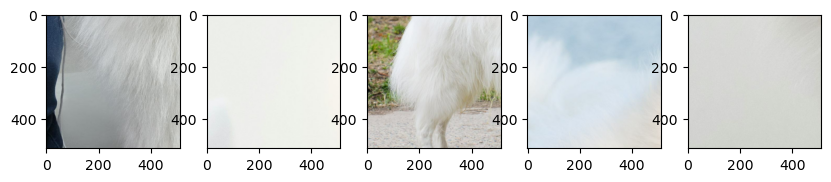

In [12]:
#cuts the image into equal pieces

DATATYPE = tf.float32
BATCHSIZE = 5

def fragmentize(input_image, 
                frame_size=512):
    result = np.array(input_image)
    crop_border = [result.shape[0]%frame_size, result.shape[1]%frame_size]
    crop_border = np.array([result.shape[0], result.shape[1]]) - crop_border
    result = result[:crop_border[0], :crop_border[1], :]
    result = result.reshape((-1, int(crop_border[0]/frame_size), crop_border[1], frame_size, 3),order='A')
    result = result.reshape((-1, frame_size, frame_size, 3),order='F')
    return result

def load_dataset(mode=1, 
                 img_size=512):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    #load from local drive
    if mode == 1:
        DIRNAME = "datasets/Dog_breed_Japanese_Spitz/"
        #DIRNAME = r"D:\dataset30102023\train"
        #DIRNAME = r"C:\Users\common\source\Jupyter\GAN based image upscaling\mscoco\mscoco_resized\val2017"
        dataset = tf.keras.utils.image_dataset_from_directory(DIRNAME,
                                                              image_size=(img_size,img_size),
                                                              labels=None,
                                                              batch_size=BATCHSIZE,
                                                              crop_to_aspect_ratio=True)
        dataset = dataset.map(lambda x:normalization_layer(x))
        dataset = dataset.map(lambda x:tf.cast(x, DATATYPE))
        return dataset
    #load from web and save on a locak drive    
    if mode == 2:
        from datasets import load_dataset
        dataset = load_dataset("Morevorot/Dog_breed_Japanese_Spitz", split="train")
        
        storage_directory = "datasets/Dog_breed_Japanese_Spitz/"
        os.makedirs(storage_directory, exist_ok=True)        
        for counter, element in enumerate(dataset):
            width, height = element["image"].size
            if width < img_size or height < img_size: continue
            batch = fragmentize(element["image"], img_size)
            for index, fragment in enumerate(batch):
                Image.fromarray(fragment).save(storage_directory + f"img-{counter}_fragment-{index}.jpg", "JPEG")       
        dataset = tf.keras.utils.image_dataset_from_directory(storage_directory,
                                                              image_size=(img_size,img_size),
                                                              labels=None,
                                                              batch_size=BATCHSIZE)
        dataset = dataset.map(lambda x:normalization_layer(x))
        dataset = dataset.map(lambda x:tf.cast(x, DATATYPE))
        return dataset

if TRAINING == True:
    train_ds = load_dataset()
    test_sample = next(iter(train_ds))
    visualize(test_sample)

In [13]:
if resotre_weights: 
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    weights_folder="weights_modver/Quality_rating/"
    postfix = "_quality_rating_model_07122023"
    model_weights_path = weights_folder + 'discriminator' + postfix
    #discriminator.load_weights(model_weights_path)

## Training parameters

In [14]:
EPOCHS = 1 #number of iterations
LIMIT = 10 #limit the dataset images to train model with

#model of training the models
#@tf.function
def fit(hr_input, epochs, data_limit=None):
    metadata_file = "logs/model_training_metadata.xlsx"
    sheet_n = "Sheet"
    if not os.path.isfile(metadata_file):
        learning_values = DataFrame(columns=["time","gen error","dis error","quantity", "delta", "batch"])
        learning_values.to_excel(metadata_file, 
                                 sheet_name=sheet_n, 
                                 index = False)
    for epoch in range(epochs):
        dataset_iterator = hr_input
        if data_limit: dataset_iterator = hr_input.take(data_limit)
        start_time = time.time()
        counter, status_line = 1, " "*100
        gen_loss_sum = 0
        dis_loss_sum = 0
        learning_values = DataFrame(columns=["time","gen error","dis error","quantity", "delta", "batch"])
        learning_values.loc[len(learning_values)] = [-1, -1, -1, 0, DELTA, BATCHSIZE]
        for batch in dataset_iterator:
            with tf.GradientTape() as g_tape:
                gen_output = generator(tf.image.resize(batch,(64,64)), training = True)
                
                dis_prediction = discriminator(gen_output, training = False)

                gen_loss = generator_loss(gen_output, batch, dis_prediction)  
                gen_loss_sum += gen_loss
                del gen_output, dis_prediction
            #apply generator gradient at the end of epoch
            gen_grads = g_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
            del gen_grads
            with tf.GradientTape() as d_tape:
                gen_output = generator(tf.image.resize(batch,(64,64)), training = False)
                
                dis_real_output = discriminator(batch, training = True)
                dis_gen_output = discriminator(gen_output, training = True)
                
                dis_loss = discriminator_loss(dis_real_output, dis_gen_output)
                dis_loss_sum += dis_loss
                del gen_output, dis_real_output, dis_gen_output
            
            #apply discriminator gradient at the end of epoch
            dis_grads = d_tape.gradient(dis_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables))
            del dis_grads
            #
            counter += 1
            status_line = f"EP:{epoch+1:<3} C:{counter} t:{int(time.time()-start_time):<4} DL:{dis_loss_sum/counter:.4f} GL:{gen_loss_sum/counter:.4f}"
            print(status_line, end="\r")
        #save, next statistic line, clear some memory
        ckpt_manager.save()
        status_line = f"EP:{epoch+1:<2} C:{counter:<5} t:{int(time.time()-start_time):<5} DL:{dis_loss_sum/counter:.4f} GL:{gen_loss_sum/counter:.4f}"
        try:
            with ExcelWriter(metadata_file, 
                             mode='a', 
                             if_sheet_exists='overlay') as writer:
                learning_values.loc[len(learning_values)-1] = [time.time()-start_time,
                                                               gen_loss_sum/counter,
                                                              dis_loss_sum/counter,
                                                              counter,
                                                              DELTA,
                                                              BATCHSIZE]
                learning_values.to_excel(writer,
                                         sheet_name=sheet_n,
                                         startrow=writer.sheets[sheet_n].max_row,
                                         index=False,
                                         header=False)
        except Exception as ex:
            print(ex)
            pass
        print(status_line)

#start training
#mode 1 is a discriminator trainer
#mode 2 is a custom model
#mode 3 is a tensorflow basic approach
if TRAINING == True:
    mode = 2
    if mode == 1:
        fit_quality_rating(train_ds, EPOCHS, data_quantity=LIMIT)
    if mode == 2:
        fit(train_ds, EPOCHS, data_limit=LIMIT)
    if mode == 3:
        generator.compile(optimizer=generator_optimizer, 
                          loss='mse',
                          metrics=['mae', 'msle'])
        
        generator.fit(tf.data.Dataset.zip((train_ds.map(lambda x: tf.image.resize(x,(64,64))), 
                                           train_ds)),
                      epochs=EPOCHS)
        ckpt_manager.save()

EP:1  C:11    t:34    DL:0.0000 GL:0.0104


# TEST

D Input: 3.6673377e-05 0.34347302 0.049460195
D Gen:    0.974427 0.9999742 0.9996394
DL:       tf.Tensor(0.05108589, shape=(), dtype=float32)
(1, 3096, 3320, 3)


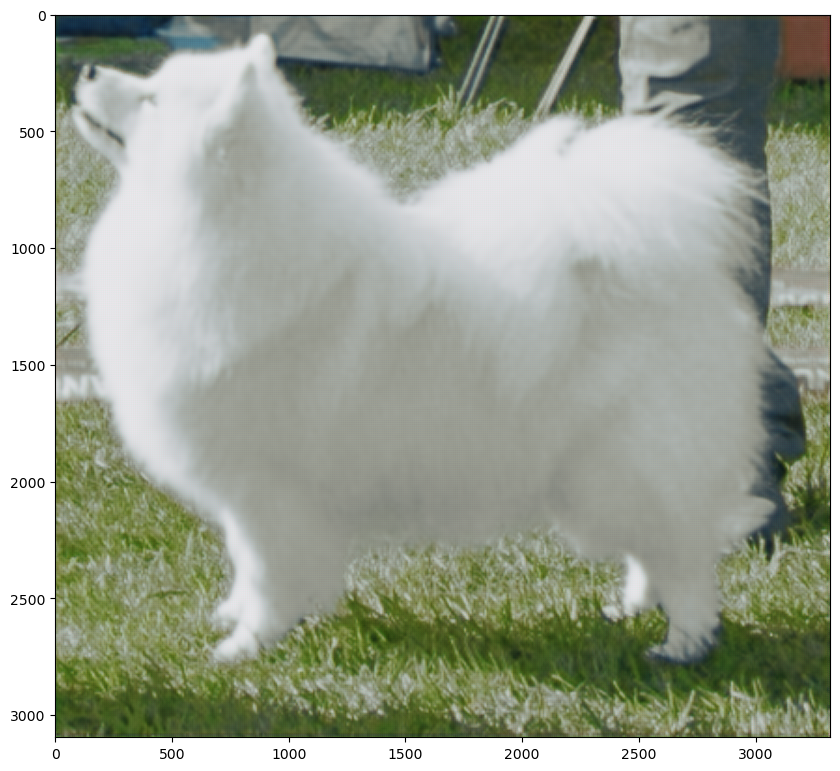

In [15]:
#selected test images processing generator and will be saved at preset folder
TEST_IMAGE_PATH = r"C:\Users\common\Pictures\spitz\input.jpg"
OUTPUT_SAVE_DIRECTORY = "C:/Users/common/Pictures/spitz/"

#choosing CPU devica because GPU resources are not freed after training
if True:
    with tf.device('/CPU:0'):
        #get data
        filename_input = TEST_IMAGE_PATH
        test_image = Image.open(filename_input)
        test_image = np.array([test_image])/255.

        #process with model
        dis_prob_input = discriminator(test_image)
        test_image = generator(test_image)
        dis_prob_gen = discriminator(test_image)

        #technical output
        print("D Input:", np.min(dis_prob_input), np.max(dis_prob_input), np.mean(dis_prob_input))
        print("D Gen:   ", np.min(dis_prob_gen), np.max(dis_prob_gen), np.mean(dis_prob_gen))
        print("DL:      ", discriminator_loss(dis_prob_input, dis_prob_gen))
        visualize(test_image)
        
        #save on drive
        name = OUTPUT_SAVE_DIRECTORY+"generated_output_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+".jpg"
        test_image = test_image.numpy()[0]*255
        test_image = Image.fromarray(test_image.astype(np.uint8))
        test_image.save(name)
        del test_image, dis_prob_input, dis_prob_gen

(5, 512, 512, 3)


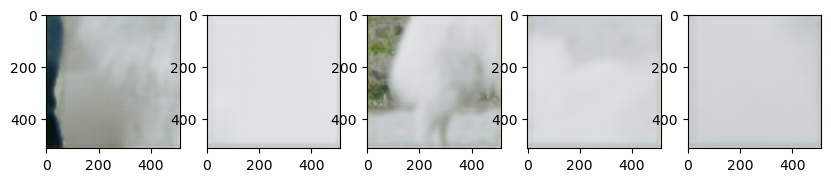

In [16]:
with tf.device('/CPU:0'):
    input_sample = tf.image.resize(test_sample,(64,64))
    output_sample = generator(input_sample)# * 255
    visualize(output_sample)
    del input_sample, output_sample

In [17]:
if False:
    postfix = "_main_07122023_basic_processing15122023"
    
    discriminator.save_weights(weights_folder + 'discriminator' + postfix)
    generator.save_weights(weights_folder + 'generator' + postfix)

    print("files:\n",
         weights_folder + 'discriminator' + postfix,"\n",
         weights_folder + 'generator' + postfix)
